In [2]:
# IMPORTACION DE LIBRERIAS
import pandas as pd
from Funciones.textblob import *
from Funciones.functions_dates import *
from Funciones.functions_json import *
import matplotlib.pyplot as plt
import pyarrow as pa
import pyarrow.parquet as pq

c:\Users\51995\AppData\Local\Programs\Python\Python310\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## **ETL - STEAM GAMES**

**OPERACIONES REALIZADAS**

DESCOMPRESIÓN Y LECTURA DEL ARCHIVO (steam-games.json.gz)

SELECCIÓN DE LAS COLUMNAS RELEVANTES (MVP)

ELIMINACIÓN DE REGISTROS VACIOS Y DUPLICADOS

TRATAMIENTO DE DATOS POR COLUMNA

DESCOMPRESION - LECTURA

In [3]:
#Descompresión del archivo con terminación (.json.gz)
df_games = descomprimirJson(r"PI MLOps - STEAM\steam_games.json.gz",0)
#Visualización del df_reviews
df_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher     24083 non-null  object
 1   genres        28852 non-null  object
 2   app_name      32133 non-null  object
 3   title         30085 non-null  object
 4   url           32135 non-null  object
 5   release_date  30068 non-null  object
 6   tags          31972 non-null  object
 7   reviews_url   32133 non-null  object
 8   specs         31465 non-null  object
 9   price         30758 non-null  object
 10  early_access  32135 non-null  object
 11  id            32133 non-null  object
 12  developer     28836 non-null  object
dtypes: object(13)
memory usage: 11.9+ MB


Selección de las columnas relevantes (MVP)

In [4]:
#Se selecciona solo las columnas que serviran para el MVP
columnas_relevantes_games = ['id','title','developer','genres','release_date','price']
#Se quedan solo las columnas relevantes en el nuevo df_reviews
df_games = df_games[columnas_relevantes_games]
#Se normaliza el nombre de la columna id a item_id
df_games.rename(columns={'id':'item_id'},inplace=True)
df_games.head()

,item_id,title,developer,genres,release_date,price
0,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN


Se observa registros completamente vacios

ELIMINACION DE REGISTROS VACIOS Y DUPLICADOS

In [5]:
df_games.dropna(inplace=True,how='all')
df_games.reset_index(drop=True,inplace=True)
df_games.head()

,item_id,title,developer,genres,release_date,price
0,761140,Lost Summoner Kitty,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,4.99
1,643980,Ironbound,Secret Level SRL,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,Free To Play
2,670290,Real Pool 3D - Poolians,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,Free to Play
3,767400,弹炸人2222,彼岸领域,"[Action, Adventure, Casual]",2017-12-07,0.99
4,773570,NaN,NaN,NaN,NaN,2.99


In [6]:
#Visualización de los registros nulos
df_games.isna().sum()

item_id            2
title           2050
developer       3299
genres          3283
release_date    2067
price           1377
dtype: int64

En este caso, se realizara un tratamiento para cada columna, ya que se presencia cantidades diferentes para cada caso

COLUMNA (item_id)

In [7]:
#Visualización de los registros nulos
df_games[df_games['item_id'].isna()]

,item_id,title,developer,genres,release_date,price
74,NaN,NaN,NaN,NaN,NaN,19.99
30961,NaN,Batman: Arkham City - Game of the Year Edition,"Rocksteady Studios,Feral Interactive (Mac)","[Action, Adventure]",2012-09-07,19.99


Para el caso del registro (74) se eliminará directamente, ya que no se puede imputar los valores faltantes

Para el caso del registro (30961) se debe revisar si existe un registro duplicado que contenga los mismos valores

In [8]:
#Se filtra el df_games para obtener solo los registros duplicados
registros_duplicados = df_games[df_games.duplicated(subset='title',keep=False)]
registros_duplicados.loc[registros_duplicados['title'] == 'Batman: Arkham City - Game of the Year Edition']

,item_id,title,developer,genres,release_date,price
1068,200260,Batman: Arkham City - Game of the Year Edition,"Rocksteady Studios,Feral Interactive (Mac)","[Action, Adventure]",2012-09-07,19.99
30961,NaN,Batman: Arkham City - Game of the Year Edition,"Rocksteady Studios,Feral Interactive (Mac)","[Action, Adventure]",2012-09-07,19.99


Al existir un registro igual con los mismos datos, se toma como duplicado el registro (30961) y se elimina

In [9]:
df_games.dropna(subset=['item_id'],inplace=True)

Por ultimo, para el tratamiento posterior de datos, convertimos la columna a entero (int)

In [10]:
df_games['item_id'] = df_games['item_id'].astype(int)

Así mismo se eliminan los registros que contienen un item_id duplicado

In [11]:
df_games.drop_duplicates(subset='item_id', inplace=True)

COLUMNA (title)

Se visualiza los registros nulos 

In [12]:
df_games[df_games['title'].isna()]

,item_id,title,developer,genres,release_date,price
4,773570,NaN,NaN,NaN,NaN,2.99
11,724910,NaN,NaN,NaN,NaN,Free
19,772590,NaN,NaN,NaN,NaN,4.99
20,640250,NaN,NaN,NaN,NaN,2.99
22,711440,NaN,NaN,NaN,NaN,0.99
...,...,...,...,...,...,...
32073,745900,NaN,NaN,NaN,NaN,19.99
32076,764110,NaN,NaN,NaN,NaN,1.99
32077,705860,NaN,NaN,NaN,NaN,Free
32085,755540,NaN,NaN,NaN,NaN,NaN


Ya que no hay forma de imputar valores a los nulos, todos los registros con titulo vacio se estableceran como 'Unknown'

In [13]:
df_games['title'] = df_games['title'].fillna("Unknown")

Por ultimo, para el tratamiento posterior de datos, convertimos la columna a string (str)

In [14]:
df_games['title'] = df_games['title'].str.strip()
df_games['title'] = df_games['title'].astype(str)

COLUMNA (developer)

Se visualiza los registros nulos

In [15]:
df_games[df_games['developer'].isna()]

,item_id,title,developer,genres,release_date,price
4,773570,Unknown,NaN,NaN,NaN,2.99
11,724910,Unknown,NaN,NaN,NaN,Free
19,772590,Unknown,NaN,NaN,NaN,4.99
20,640250,Unknown,NaN,NaN,NaN,2.99
22,711440,Unknown,NaN,NaN,NaN,0.99
...,...,...,...,...,...,...
32118,775640,Robotpencil Presents: Exercise: Brushwork,NaN,NaN,2018-01-03,3.99
32119,777930,Robotpencil Presents: Creative Composition,NaN,NaN,2018-01-03,3.99
32120,775370,The Gamble House,NaN,NaN,2016-11-19,4.99
32121,777950,Kalen Chock Presents: 2017 Free Tutorial,NaN,NaN,2018-01-03,Free


Ya que no hay forma de imputar valores a los nulos, todos los registros con titulo vacio se estableceran como 'Unknown'

In [16]:
df_games['developer'] = df_games['developer'].fillna("Unknown")

Por ultimo, para el tratamiento posterior de datos, convertimos la columna a string (str)

In [17]:
df_games['developer'] = df_games['developer'].str.strip()
df_games['developer'] = df_games['developer'].astype(str)

COLUMNA (genres)

Se visualiza los registros

In [18]:
#Se separa a los genres por coma (,)
genres_str = df_games["genres"].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x))
#Se divide la columna 'genres' en géneros individuales y después se crea un conjunto de géneros únicos
gneres_unicos = set(genres_str.str.split(',').explode().str.strip())
print(list(gneres_unicos))

['Simulation', 'Education', 'Photo Editing', 'Free to Play', 'Sports', 'Video Production', 'Audio Production', 'Software Training', 'Indie', 'Strategy', 'nan', 'Early Access', 'Design &amp; Illustration', 'Action', 'Racing', 'Web Publishing', 'Adventure', 'RPG', 'Casual', 'Accounting', 'Massively Multiplayer', 'Animation &amp; Modeling', 'Utilities']


Se observa que los registros se encuentran dentro de listas, así como tres registros anormales, que son 'Animation &amp ; Modeling',  'Design &amp ; Illustration' y 'nan', de igual manera se encuentran valores nulos

In [19]:
#Se convierte a string la lista y se separa a los genres por coma (,)
df_games["genres"] = df_games["genres"].apply(lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x)).str.strip()
#Se verifica y asigna "Unknown" a registros nulos y vacios en la columna "genres"
df_games['genres'] = df_games['genres'].apply(lambda x: "Unknown" if x == 'nan' else x)
df_games['genres'] = df_games['genres'].apply(lambda x: "Unknown" if x == '' else x)
#Se reemplaza la cadena 'Design &amp; ' y 'Design &amp; ' por valores vacios
df_games['genres'] = df_games['genres'].str.replace('Design &amp; ', '')
df_games['genres'] = df_games['genres'].str.replace('Animation &amp; ', '')
df_games['genres'] = df_games['genres'].str.rstrip(', ')

In [20]:
#Visualización de los registros nulos
df_games.isna().sum()

item_id            0
title              0
developer          0
genres             0
release_date    2066
price           1377
dtype: int64

COLUMNA(release_date)

Se visualiza los registros nulos

In [21]:
df_games[df_games['release_date'].isna()]

,item_id,title,developer,genres,release_date,price
4,773570,Unknown,Unknown,Unknown,NaN,2.99
11,724910,Unknown,Unknown,Unknown,NaN,Free
19,772590,Unknown,Unknown,Unknown,NaN,4.99
20,640250,Unknown,Unknown,Unknown,NaN,2.99
22,711440,Unknown,Unknown,Unknown,NaN,0.99
...,...,...,...,...,...,...
32077,705860,Unknown,Unknown,Unknown,NaN,Free
32084,729640,BOMBFEST,The BOMBFEST Team,"Action, Casual, Indie",NaN,NaN
32085,755540,Unknown,Unknown,Unknown,NaN,NaN
32088,708070,RECHARGE COMPLETE,rechargecomplete,"Action, Adventure, Indie, Early Access",NaN,NaN


Al no poder imputar valores en release date, se establece una fecha por defecto

In [22]:
#Se comprueba que la fecha por defecto (1970-01-01) a imputar no se encuentre ya dentro de los registros
df_games[df_games['release_date'].str.strip() == '1970-01-01'].shape[0]

0

In [23]:
#Se imputa la fecha por defecto a los registros nulos
df_games['release_date'].fillna(pd.to_datetime('1970-01-01').date().strftime('%Y-%m-%d'),inplace=True)
#Se visualiza que no queden registros nulos
df_games[df_games['release_date'].isna()]

,item_id,title,developer,genres,release_date,price


La columna contiene registros anómalos por lo cual, a esto registros se les imputará valores según el caso

In [24]:
df_games['release_date'] = df_games['release_date'].astype(str)
df_games['release_date'] = df_games['release_date'].str.strip()
#Convierte todos los registros a datos tipo fecha
df_games['release_date'] = df_games['release_date'].apply(convertReleaseFuzzy)

COLUMNA (price)

Se agrega en una nueva columna los registros de la columna price que se puedan convertir a numéricos

In [25]:
df_games['new_price'] = pd.to_numeric(df_games['price'], errors='coerce')

In [26]:
#Se visualiza los registros nulos
df_games[df_games['new_price'].isna()]

,item_id,title,developer,genres,release_date,price,new_price
1,643980,Ironbound,Secret Level SRL,"Free to Play, Indie, RPG, Strategy",2018-01-04,Free To Play,NaN
2,670290,Real Pool 3D - Poolians,Poolians.com,"Casual, Free to Play, Indie, Simulation, Sports",2017-07-24,Free to Play,NaN
9,768800,Race,RewindApp,"Casual, Indie, Racing, Simulation",2018-01-04,NaN,NaN
10,768570,Uncanny Islands,Qucheza,"Action, Indie, Simulation, Early Access",1970-07-01,NaN,NaN
11,724910,Unknown,Unknown,Unknown,1970-01-01,Free,NaN
...,...,...,...,...,...,...,...
32111,90007,International Online Soccer,I.O.S. Team,Sports,2002-01-01,NaN,NaN
32121,777950,Kalen Chock Presents: 2017 Free Tutorial,Unknown,Unknown,2018-01-03,Free,NaN
32123,772180,Cricket Club,VersoVR,"Casual, Indie, Simulation, Sports, Early Access",2018-07-01,NaN,NaN
32125,771810,The spy who shot me™,Retro Army Limited,"Action, Adventure, Indie",2018-10-01,NaN,NaN


Se visualiza valores anómalos en price

In [27]:
df_games[df_games['new_price'].isna()]['price'].unique()

array(['Free To Play', 'Free to Play', nan, 'Free', 'Free Demo',
       'Play for Free!', 'Install Now', 'Play WARMACHINE: Tactics Demo',
       'Free Mod', 'Install Theme', 'Third-party', 'Play Now',
       'Free HITMAN™ Holiday Pack', 'Play the Demo',
       'Starting at $499.00', 'Starting at $449.00', 'Free to Try',
       'Free Movie', 'Free to Use'], dtype=object)

Para aquellos registros que contengan la palabra Free se modificara su precio, para los que comiencen con 'Starting at ' se les eliminará el texto y para los demás se establecerá como valores vacios

In [28]:
#Valores con 'Starting at'
df_games['price'] = df_games['price'].apply(lambda x: x.replace('Starting at $', '') if isinstance(x, str) and 'Starting at $' in x else x)
#Valores con 'Free'
df_games.loc[df_games['price'].str.contains('free', case=False, na=False), 'price'] = 0.0
df_games['new_price'] = pd.to_numeric(df_games['price'], errors='coerce')
#Reemplazamos en la columna original
df_games['price'] = df_games['new_price']
df_games.drop('new_price', axis=1, inplace=True)

En este caso, se imputaran valores para los demas registros que esten nulos

In [29]:
#Se imputa 9.99 para los valores nulos restantes
df_games['price'].fillna(9.99, inplace=True)

In [30]:
#Visualizamos los cambios
df_games.head()

,item_id,title,developer,genres,release_date,price
0,761140,Lost Summoner Kitty,Kotoshiro,"Action, Casual, Indie, Simulation, Strategy",2018-01-04,4.99
1,643980,Ironbound,Secret Level SRL,"Free to Play, Indie, RPG, Strategy",2018-01-04,0.00
2,670290,Real Pool 3D - Poolians,Poolians.com,"Casual, Free to Play, Indie, Simulation, Sports",2017-07-24,0.00
3,767400,弹炸人2222,彼岸领域,"Action, Adventure, Casual",2017-12-07,0.99
4,773570,Unknown,Unknown,Unknown,1970-01-01,2.99


## **ETL - USER REVIEWS**

**OPERACIONES REALIZADAS**

DESCOMPRESIÓN Y LECTURA DEL ARCHIVO (user_reviews.json.gz)

DESANIDADO DE COLUMNA (reviews)

SELECCIÓN DE COLUMNAS RELEVANTES (MVP)

ELIMINACIÓN DE REGISTROS DUPLICADOS

ELIMINACIÓN DE REGISTROS NULOS

TRATAMIENTO POR COLUMNAS

ANÁLISIS DE SENTIMIENTOS (reviews)

DESCOMPRESION - LECTURA

In [31]:
#Descompresión del archivo con terminación (.json.gz)
df_reviews = descomprimirJson(r"PI MLOps - STEAM\user_reviews.json.gz",1)
#Visualización del df_reviews
df_reviews.head()

,user_id,user_url,reviews
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'funny': '', 'posted': 'Posted November 5, 2..."
1,js41637,http://steamcommunity.com/id/js41637,"[{'funny': '', 'posted': 'Posted June 24, 2014..."
2,evcentric,http://steamcommunity.com/id/evcentric,"[{'funny': '', 'posted': 'Posted February 3.',..."
3,doctr,http://steamcommunity.com/id/doctr,"[{'funny': '', 'posted': 'Posted October 14, 2..."
4,maplemage,http://steamcommunity.com/id/maplemage,"[{'funny': '3 people found this review funny',..."


Se visualiza que la columna reviews contiene datos anidados

DESANIDADO DE LA COLUMNA (reviews)

In [32]:
df_reviews = desanidarJson(df_reviews,'reviews')
df_reviews.head()

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted November 5, 2011.",,1250,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted July 15, 2011.",,22200,No ratings yet,True,It's unique and worth a playthrough.
2,76561197970982479,http://steamcommunity.com/profiles/76561197970...,,"Posted April 21, 2011.",,43110,No ratings yet,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,http://steamcommunity.com/id/js41637,,"Posted June 24, 2014.",,251610,15 of 20 people (75%) found this review helpful,True,I know what you think when you see this title ...
4,js41637,http://steamcommunity.com/id/js41637,,"Posted September 8, 2013.",,227300,0 of 1 people (0%) found this review helpful,True,For a simple (it's actually not all that simpl...


Selección de las columnas relevantes (MVP)

In [33]:
#Se selecciona solo las columnas que serviran para el MVP
columnas_relevantes_reviews = ['user_id','posted','item_id','recommend','review']
#Se quedan solo las columnas relevantes en el nuevo df_reviews
df_reviews = df_reviews[columnas_relevantes_reviews]
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59333 entries, 0 to 59332
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    59333 non-null  object
 1   posted     59305 non-null  object
 2   item_id    59305 non-null  object
 3   recommend  59305 non-null  object
 4   review     59305 non-null  object
dtypes: object(5)
memory usage: 2.3+ MB


Eliminación de registros duplicados

In [34]:
df_reviews.drop_duplicates(inplace=True)
df_reviews.reset_index(drop=True,inplace=True)
#Se visualiza el cambio de cantidad registros
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58459 entries, 0 to 58458
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    58459 non-null  object
 1   posted     58431 non-null  object
 2   item_id    58431 non-null  object
 3   recommend  58431 non-null  object
 4   review     58431 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


Eliminación de registros nulos

In [35]:
#Visualización de los registros nulos
df_reviews[df_reviews.isna().any(axis=1)]

,user_id,posted,item_id,recommend,review
137,gdxsd,NaN,NaN,NaN,NaN
177,76561198094224872,NaN,NaN,NaN,NaN
2558,76561198021575394,NaN,NaN,NaN,NaN
9956,cmuir37,NaN,NaN,NaN,NaN
13528,Jaysteeny,NaN,NaN,NaN,NaN
15212,ML8989,NaN,NaN,NaN,NaN
18792,76561198079215291,NaN,NaN,NaN,NaN
19784,76561198079342142,NaN,NaN,NaN,NaN
24522,76561198061996985,NaN,NaN,NaN,NaN
25716,76561198108286351,NaN,NaN,NaN,NaN


In [36]:
#Al encontrar registros vacios en las columnas ['posted','item_id','recommend','review'] no se pueden imputar, por lo cual se eliminan
df_reviews.dropna(inplace=True)
df_reviews.reset_index(drop=True,inplace=True)
#Se visualiza el cambio de cantidad registros
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58431 entries, 0 to 58430
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   user_id    58431 non-null  object
 1   posted     58431 non-null  object
 2   item_id    58431 non-null  object
 3   recommend  58431 non-null  object
 4   review     58431 non-null  object
dtypes: object(5)
memory usage: 2.2+ MB


Para el tratamiento posterior de datos, convertimos la columna item_id a entero (int)

In [37]:
df_reviews['item_id'] = df_reviews['item_id'].astype(int)
df_reviews.head(10)

,user_id,posted,item_id,recommend,review
0,76561197970982479,"Posted November 5, 2011.",1250,True,Simple yet with great replayability. In my opi...
1,76561197970982479,"Posted July 15, 2011.",22200,True,It's unique and worth a playthrough.
2,76561197970982479,"Posted April 21, 2011.",43110,True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,"Posted June 24, 2014.",251610,True,I know what you think when you see this title ...
4,js41637,"Posted September 8, 2013.",227300,True,For a simple (it's actually not all that simpl...
5,js41637,"Posted November 29, 2013.",239030,True,Very fun little game to play when your bored o...
6,evcentric,Posted February 3.,248820,True,A suitably punishing roguelike platformer. Wi...
7,evcentric,"Posted December 4, 2015.",370360,True,"""Run for fun? What the hell kind of fun is that?"""
8,evcentric,"Posted November 3, 2014.",237930,True,"Elegant integration of gameplay, story, world ..."
9,evcentric,"Posted October 15, 2014.",263360,True,"Random drops and random quests, with stat poin..."


La columna 'posted' contiene fechas incompletas y con el formato inadecuado

In [38]:
df_reviews['posted'] = df_reviews['posted'].str.strip()
#Se elimina el prefijo 'Posted ' y el caracter '.'
df_reviews['posted'] = df_reviews['posted'].str.replace('Posted ','').str.replace('.','')
#Se aplica la función de conversión
df_reviews['new_posted'] = df_reviews['posted'].apply(conv_posted) 
df_reviews.head(10)

,user_id,posted,item_id,recommend,review,new_posted
0,76561197970982479,"November 5, 2011",1250,True,Simple yet with great replayability. In my opi...,2011-11-05
1,76561197970982479,"July 15, 2011",22200,True,It's unique and worth a playthrough.,2011-07-15
2,76561197970982479,"April 21, 2011",43110,True,Great atmosphere. The gunplay can be a bit chu...,2011-04-21
3,js41637,"June 24, 2014",251610,True,I know what you think when you see this title ...,2014-06-24
4,js41637,"September 8, 2013",227300,True,For a simple (it's actually not all that simpl...,2013-09-08
5,js41637,"November 29, 2013",239030,True,Very fun little game to play when your bored o...,2013-11-29
6,evcentric,February 3,248820,True,A suitably punishing roguelike platformer. Wi...,1900-02-03
7,evcentric,"December 4, 2015",370360,True,"""Run for fun? What the hell kind of fun is that?""",2015-12-04
8,evcentric,"November 3, 2014",237930,True,"Elegant integration of gameplay, story, world ...",2014-11-03
9,evcentric,"October 15, 2014",263360,True,"Random drops and random quests, with stat poin...",2014-10-15


In [39]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58431 entries, 0 to 58430
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58431 non-null  object
 1   posted      58431 non-null  object
 2   item_id     58431 non-null  int32 
 3   recommend   58431 non-null  object
 4   review      58431 non-null  object
 5   new_posted  58431 non-null  object
dtypes: int32(1), object(5)
memory usage: 2.5+ MB


In [40]:
#Se cambia el formato de la columna
df_reviews['new_posted'] = pd.to_datetime(df_reviews['new_posted'])

Para aquellos registros que se les establecio una fecha de 1900, se pueden imputar valores según el item_id de la fecha de lanzamiento que se tiene en el df_games

In [41]:
#Se obtienen los registros con año 1900
df_reviews_con_filtro = df_reviews.loc[df_reviews['new_posted'].dt.year == 1900]

for indice, fila in df_reviews_con_filtro.iterrows():
    item_id = fila['item_id']  # Obtiene el valor de 'item_id' de df_user_reviews
    
    # Busca las coincidencias para item_id en df_output_steam_json
    coincidencias = df_games[df_games['item_id'] == item_id]
    
    # Verifica si se encontraron coincidencias antes de intentar acceder al valor
    if not coincidencias.empty:
        # Se obtiene el primer valor de 'release_date' en las coincidencias
        anio_release = coincidencias['release_date'].str[:4].values[0]
        fecha_posted = df_reviews.at[indice, 'new_posted']                                  
        nueva_fecha = fecha_posted.replace(year=int(anio_release)+1)

        # Se asigna la nueva fecha a 'new_posted' en el DataFrame
        df_reviews.at[indice, 'new_posted'] = nueva_fecha


In [42]:
#Se visualiza que aun se encuentran registros con un año arbitrario
df_reviews_con_filtro = df_reviews.loc[df_reviews['new_posted'].dt.year == 1900]
df_reviews_con_filtro

,user_id,posted,item_id,recommend,review,new_posted
91,76561198170198366,January 18,271290,True,Best mech game I have ever played,1900-01-18
111,76561198070194565,April 4,246280,True,отличная игра советую всем только жалко что ту...,1900-04-04
183,Nozomikat,August 19,437220,False,Very harsh to new players. Combat system is st...,1900-08-19
295,ohnospaghet,January 16,369200,True,sat in the lobby for half an hour and found a ...,1900-01-16
298,76561198050347115,March 19,292030,True,quit my job 8 months ago to play this game ful...,1900-03-19
...,...,...,...,...,...,...
58317,76561198208704549,February 19,407250,True,Arkadaşlarla oynandığında eğlenceli.,1900-02-19
58333,76561198209894493,May 1,414390,True,NABOR NAGIBA + GOLD CARD XD,1900-05-01
58379,wayfeng,May 22,369200,True,MOTOKO MOTOKO MOTOKO MOTOKO MOTOKO MOTOKO MOTO...,1900-05-22
58404,76561198270958927,July 3,381210,True,"Fix your ♥♥♥♥ing game, de rank me for no reaso...",1900-07-03


Para los registros que no encontraron una coincidencia con el df_games, se les establecerá como year por defecto 1970

In [43]:
#Se convierte todos los registros con año 1900 a 1970
df_reviews['new_posted'] = df_reviews['new_posted'].apply(lambda date: date.replace(year=1970) if date.year == 1900 else date)
#Se visualiza si quedo algun registro por cambiar
df_reviews.loc[df_reviews['new_posted'].dt.year == 1900].shape[0]

0

Se reemplaza los valores en la columna original

In [44]:
df_reviews['posted'] = df_reviews['new_posted']
df_reviews.drop('new_posted', axis=1, inplace=True)

Para la columna recommend tan solo se convierte a enteros(int)

In [45]:
df_reviews['recommend'] = df_reviews['recommend'].astype(int)

Se realiza un análisis de sentimiento para la columna 'review'

In [46]:
df_reviews = pd.concat([df_reviews, sentimientoTextblob(df_reviews['review'], 'sentiment_analysis')], axis = 1)
df_reviews.head()

,user_id,posted,item_id,recommend,review,sentiment_analysis
0,76561197970982479,2011-11-05,1250,1,Simple yet with great replayability. In my opi...,1
1,76561197970982479,2011-07-15,22200,1,It's unique and worth a playthrough.,2
2,76561197970982479,2011-04-21,43110,1,Great atmosphere. The gunplay can be a bit chu...,1
3,js41637,2014-06-24,251610,1,I know what you think when you see this title ...,1
4,js41637,2013-09-08,227300,1,For a simple (it's actually not all that simpl...,1


Para su posterior tratamiento se convierte la columna 'sentyment_analysis' a entero (int)

In [47]:
df_reviews['sentiment_analysis'] = df_reviews['sentiment_analysis'].astype(int)

## **ETL - USERS ITEMS**

**OPERACIONES REALIZADAS**

DESCOMPRESIÓN Y LECTURA DEL ARCHIVO (users_items.json.gz)

DESANIDADO DE COLUMNA (items)

ELIMINACIÓN DE REGISTROS DUPLICADOS

TRATAMIENTO DE COLUMNAS

In [48]:
#Descompresión del archivo con terminación (.json.gz)
df_items = descomprimirJson(r"PI MLOps - STEAM\users_items.json.gz",1)
#Visualización del df_items
df_items.head()

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864385,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712555,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445855,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099482,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."


Se visualiza que la columna reviews contiene datos anidados

DESANIDADO DE LA COLUMNA (items)

In [49]:
df_items = desanidarJson(df_items,'items')
df_items.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0


In [50]:
df_items.head()

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
0,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,10,Counter-Strike,6.0,0.0
1,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,20,Team Fortress Classic,0.0,0.0
2,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,30,Day of Defeat,7.0,0.0
3,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,40,Deathmatch Classic,0.0,0.0
4,76561197970982479,277,76561197970982479,http://steamcommunity.com/profiles/76561197970...,50,Half-Life: Opposing Force,0.0,0.0


Selección de las columnas relevantes (MVP)

In [51]:
#Se selecciona solo las columnas que serviran para el MVP, en este caso se utilizará 'playtime_2weeks' para el tratamiento de datos y luego se dropeará
columnas_relevantes_items = ['user_id','item_id','playtime_forever','playtime_2weeks']
#Se quedan solo las columnas relevantes en el nuevo df_reviews
df_items = df_items[columnas_relevantes_items]
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5170015 entries, 0 to 5170014
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   item_id           object 
 2   playtime_forever  float64
 3   playtime_2weeks   float64
dtypes: float64(2), object(2)
memory usage: 157.8+ MB


Para el tratamiento posterior de datos, aquellos registros de la columna 'item_id' que esten vacios se les imputa un valor de -1

In [52]:
df_items['item_id'].fillna(-1, inplace=True)
df_items['item_id'] = df_items['item_id'].astype(int)

Eliminación de registros duplicados

In [53]:
df_items.drop_duplicates(inplace=True)
#Se visualiza el cambio de cantidad registros
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5110819 entries, 0 to 5170014
Data columns (total 4 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   item_id           int32  
 2   playtime_forever  float64
 3   playtime_2weeks   float64
dtypes: float64(2), int32(1), object(1)
memory usage: 175.5+ MB


In [54]:
#Visualización de los registros nulos
df_items.isna().sum()

user_id                 0
item_id                 0
playtime_forever    16714
playtime_2weeks     16714
dtype: int64

Se tiene la misma cantidad de valores nulos en 'playtime_forever' y 'playtime_2weeks'. Se debe comprobar si es en los mismos casos

In [55]:
df_items[(df_items['playtime_2weeks'].isna()) & (df_items['playtime_forever'].isna())].shape[0]

16714

Al estar relacionadas ambas columnas y no siendo posible imputar valores se establece como 0

In [56]:
df_items.loc[(df_items['playtime_2weeks'].isna()) & (df_items['playtime_forever'].isna()), ['playtime_2weeks', 'playtime_forever']] = 0.0
df_items.reset_index(drop=True, inplace=True)

Para aquellos registros que tengan valores en 'playtime_2weeks' y no en 'playtime_forever', se reemplazará el valor de una a la otra

In [57]:
#Se cambia el tipo de dato para poder trabajarlo
df_items['playtime_forever'] = df_items['playtime_forever'].astype(float)
df_items['playtime_2weeks']  = df_items['playtime_2weeks'].astype(float)
#Se establece el filtro
filtro = ((df_items['playtime_forever'] == 0) & (df_items['playtime_2weeks'] != 0))
df_items.loc[filtro, 'playtime_forever'] = df_items.loc[filtro, 'playtime_2weeks']

In [58]:
#Se dropea la columna 'playtime_2weeks'
df_items = df_items.drop('playtime_2weeks', axis=1)

Para la columna 'playtime' se revisa si existen outliers

In [59]:
# Calcula la media y la desviación estándar de la columna 'playtime_forever'
mean_playtime = df_items['playtime_forever'].mean()
std_playtime = df_items['playtime_forever'].std()

# Define los límites para identificar outliers utilizando el método de 3 sigmas
lower_limit = mean_playtime - 3 * std_playtime
upper_limit = mean_playtime + 3 * std_playtime

# Encuentra outliers
outliers = df_items[(df_items['playtime_forever'] < lower_limit) | (df_items['playtime_forever'] > upper_limit)]

# Imprime los outliers
print("Outliers en la columna 'playtime_forever' utilizando el método de 3 sigmas:")
print(outliers[['item_id', 'playtime_forever']])

Outliers en la columna 'playtime_forever' utilizando el método de 3 sigmas:
         item_id  playtime_forever
178          730           23532.0
1301      466170           28545.0
1354       12210           52062.0
1361       21660           23903.0
1907         730           19800.0
...          ...               ...
5108176      730           18799.0
5108397   304930           17586.0
5108553      730           29789.0
5110160   304930           20201.0
5110189      730           20016.0

[53469 rows x 2 columns]


Imputación de 'playtime_forever' a aquellos registros que son outliers

In [60]:
#Se calcula la media de los registros que no son outliers
non_outliers_mean = df_items[~((df_items['playtime_forever'] < lower_limit) | (df_items['playtime_forever'] > upper_limit))]['playtime_forever'].mean()
#Se reemplaza los valores atípicos por la media de los no outliers
df_items.loc[(df_items['playtime_forever'] < lower_limit) | (df_items['playtime_forever'] > upper_limit), 'playtime_forever'] = non_outliers_mean

De igual manera se revisa, si al agrupar el playtime_forever por usuarios se encuentran outliers

In [61]:
#Se agrupa el playtime_forever por cada usuario
user_playtime = df_items.groupby('user_id')['playtime_forever'].sum().reset_index()
mean_playtime = user_playtime['playtime_forever'].mean()
std_playtime = user_playtime['playtime_forever'].std()

#Se definen los límites para identificar outliers 
lower_limit = mean_playtime - 3 * std_playtime
upper_limit = mean_playtime + 3 * std_playtime

#Se identifican los outliers
outliers = user_playtime[(user_playtime['playtime_forever'] < lower_limit) | (user_playtime['playtime_forever'] > upper_limit)]
#Se eliminan los usuarios que se considera que su playtime_forever agrupado son outliers y afectarán al análisis de datos y endpoints
df_items = df_items[~df_items['user_id'].isin(outliers['user_id'])]
#En este caso en particular ya que se eliminan usuarios del df_items, aquellos usuarios que realizaron reviews del df_reviews tambien serán eliminados
df_reviews = df_reviews[~df_reviews['user_id'].isin(outliers['user_id'])]
df_items.head()

,user_id,item_id,playtime_forever
277,js41637,10,0.0
278,js41637,80,0.0
279,js41637,100,0.0
280,js41637,300,220.0
281,js41637,30,0.0


In [62]:
#Se visualiza el df_items
df_items

,user_id,item_id,playtime_forever
277,js41637,10,0.0
278,js41637,80,0.0
279,js41637,100,0.0
280,js41637,300,220.0
281,js41637,30,0.0
...,...,...,...
5110814,76561198329548331,373330,0.0
5110815,76561198329548331,388490,3.0
5110816,76561198329548331,521570,4.0
5110817,76561198329548331,519140,3.0


## **EDA - STEAM GAMES**

**OPERACIONES REALIZADAS**

ANALISIS DE LA ESTRUCTURA DE LOS DATOS

GRAFICOS DE BARRAS ('DISTRIBUCION DE PRECIOS DE JUEGOS','CANTIDAD DE JUEGOS POR GÉNERO', 'LANZAMIENTO DE JUEGOS POR AÑO')

BOXPLOT DE PRICE

In [63]:
df_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32132 entries, 0 to 32134
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       32132 non-null  int32  
 1   title         32132 non-null  object 
 2   developer     32132 non-null  object 
 3   genres        32132 non-null  object 
 4   release_date  32132 non-null  object 
 5   price         32132 non-null  float64
dtypes: float64(1), int32(1), object(4)
memory usage: 1.6+ MB


DISTRIBUCION DE PRECIOS DE JUEGOS

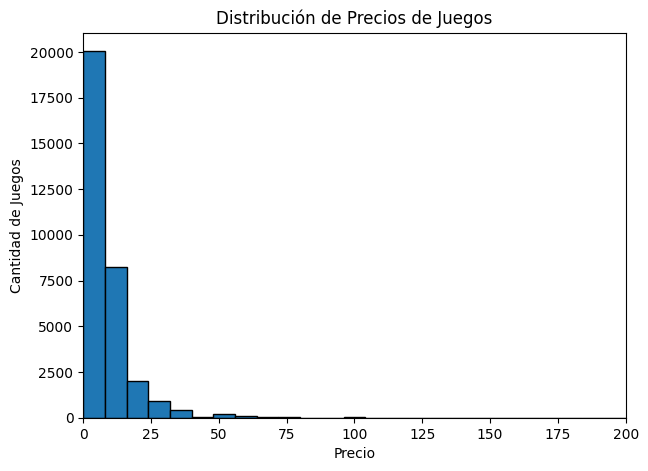

In [64]:
#Se grafica la distribución
plt.figure(figsize=(7, 5))
plt.hist(df_games['price'].dropna(), bins=25, range=(0, 200), edgecolor='k')
plt.title('Distribución de Precios de Juegos')
plt.xlabel('Precio')
plt.ylabel('Cantidad de Juegos')
plt.xlim(0, 200)
plt.show()

DISTRIBUCION DE JUEGOS POR GENERO

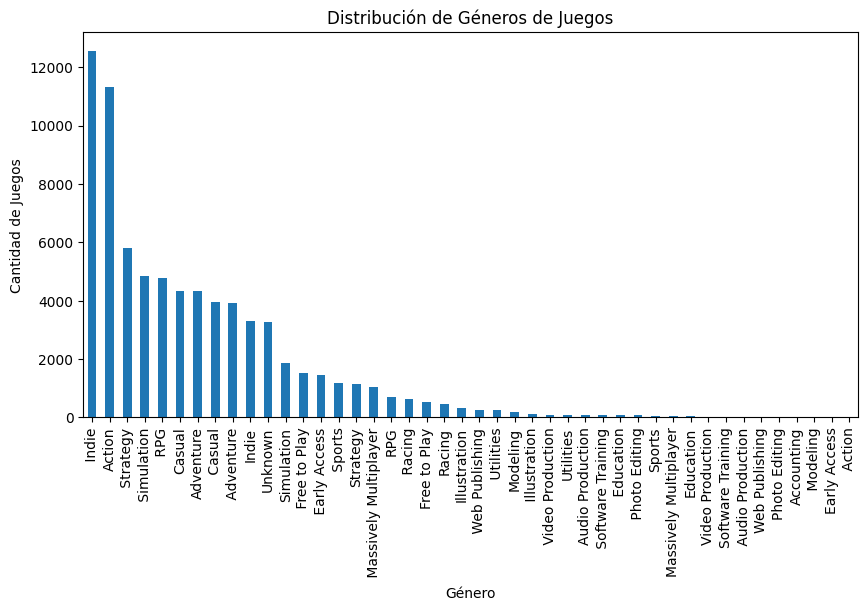

In [65]:
#Se cuenta los juegos por género
contador_genre = df_games['genres'].str.split(',').explode().value_counts()
#Se grafica la distribución
plt.figure(figsize=(10, 5))
contador_genre.plot(kind='bar')
plt.title('Distribución de Géneros de Juegos')
plt.xlabel('Género')
plt.ylabel('Cantidad de Juegos')
plt.xticks(rotation=90)
plt.show()

LANZAMIENTOS DE JUEGOS POR AÑO

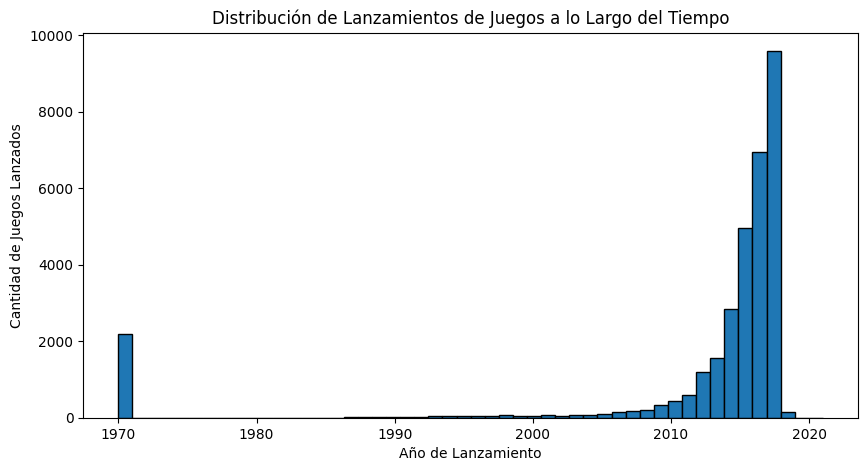

In [66]:
#Se trabaja sobre una copia del df para no modificar los datos
df_games_copy = df_games.copy()
df_games_copy['release_date'] = pd.to_datetime(df_games_copy['release_date'], errors='coerce')

#Se extrae el año de lanzamiento
df_games_copy['release_year'] = df_games_copy['release_date'].dt.year

#Se graficar la distribución
plt.figure(figsize=(10, 5))
plt.hist(df_games_copy['release_year'], bins=50, edgecolor='k')
plt.title('Distribución de Lanzamientos de Juegos a lo Largo del Tiempo')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Cantidad de Juegos Lanzados')
plt.show()

BOXPLOT DE PRICE

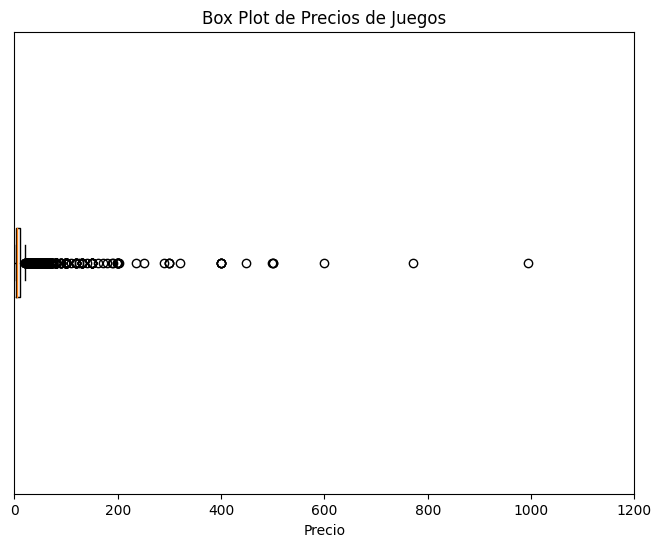

In [67]:
#Se grafica un boxplot de 'price'
plt.figure(figsize=(8, 6))
plt.boxplot(df_games['price'], vert=False)
plt.title('Box Plot de Precios de Juegos')
plt.xlabel('Precio')
plt.yticks([])
plt.xlim(0, 1200) 
plt.show()

Se pueden observar valores que se encuentran alejados de la distribución mas no van a ser eliminados ya que se considera como parte representativa de la columna Price

## **EDA - USER REVIEWS**

**OPERACIONES REALIZADAS**

ANALISIS DE LA ESTRUCTURA DE LOS DATOS

GRAFICOS DE BARRAS ('DISTRIBUCION DE RECOMENDACIONES', 'DISTRIBUCION DE SENTIMIENTOS')

ANALISIS DE LOS DATOS

In [68]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55622 entries, 3 to 58430
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   user_id             55622 non-null  object        
 1   posted              55622 non-null  datetime64[ns]
 2   item_id             55622 non-null  int32         
 3   recommend           55622 non-null  int32         
 4   review              55622 non-null  object        
 5   sentiment_analysis  55622 non-null  int32         
dtypes: datetime64[ns](1), int32(3), object(2)
memory usage: 2.3+ MB


DISTRIBUCION DE RECOMENDACIONES

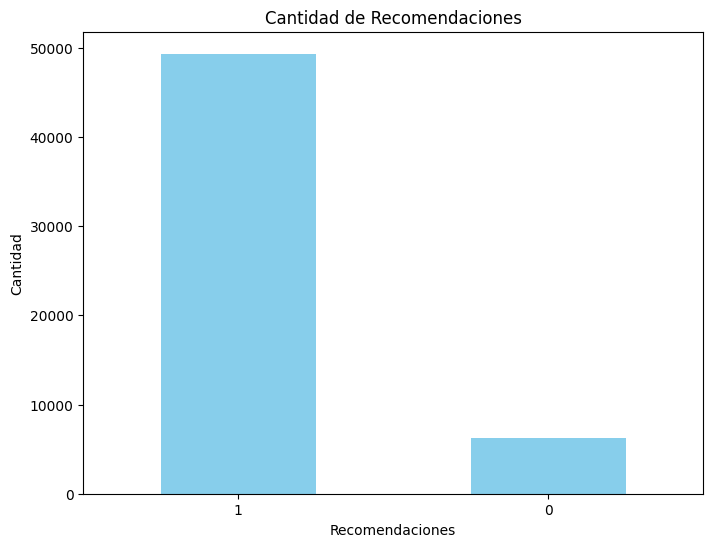

In [69]:
#Se cuenta las recomendaciones por categoría
contador_recommend = df_reviews['recommend'].value_counts()

#Se grafica la distribución
plt.figure(figsize=(8, 6))
contador_recommend.plot(kind='bar', color='skyblue')

plt.title('Cantidad de Recomendaciones')
plt.xlabel('Recomendaciones')
plt.ylabel('Cantidad')
plt.xticks(rotation=0)

plt.show()

DISTRIBUCION DE ANALISIS DE SENTIMIENTOS

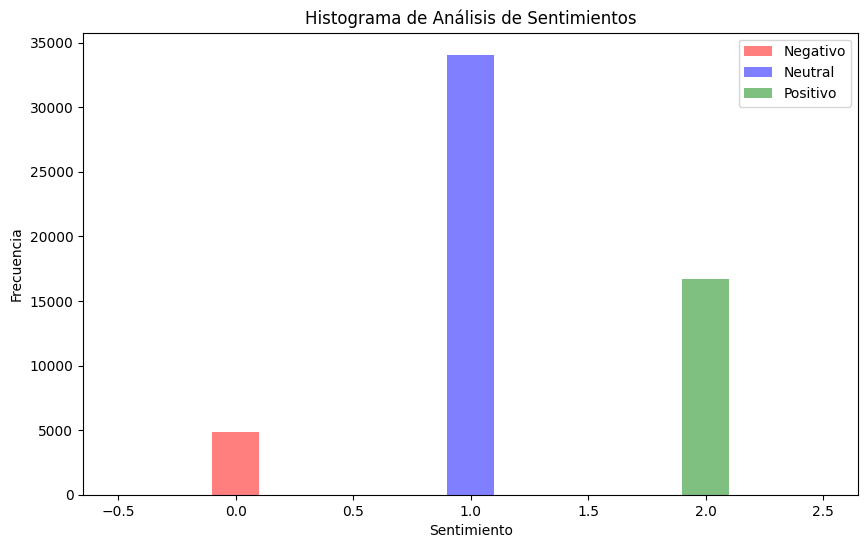

In [70]:
#Se realiza filtros para cada valor
sentiment_0 = df_reviews[df_reviews['sentiment_analysis'] == 0]
sentiment_1 = df_reviews[df_reviews['sentiment_analysis'] == 1]
sentiment_2 = df_reviews[df_reviews['sentiment_analysis'] == 2]

# Se grafica la distribucion
plt.figure(figsize=(10, 6))
plt.hist(sentiment_0['sentiment_analysis'], bins=5, color='red', alpha=0.5, label='Negativo')
plt.hist(sentiment_1['sentiment_analysis'], bins=5, color='blue', alpha=0.5, label='Neutral')
plt.hist(sentiment_2['sentiment_analysis'], bins=5, color='green', alpha=0.5, label='Positivo')
plt.title('Histograma de Análisis de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.legend()

plt.show()

## **EDA - USER ITEMS**

**OPERACIONES REALIZADAS**

ANALISIS DE LA ESTRUCTURA DE LOS DATOS

HISTOGRAMA ('HISTOGRAMA DE TIEMPO DE JUEGO')

GRAFICO DE BARRA ('DISTRIBUCION DE JUEGOS MAS JUGADOS')

DIAGRAMA DE DISPERSION ('Tiempo de juego / Cantidad de juegos por usuario')

In [71]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4533886 entries, 277 to 5110818
Data columns (total 3 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user_id           object 
 1   item_id           int32  
 2   playtime_forever  float64
dtypes: float64(1), int32(1), object(1)
memory usage: 121.1+ MB


HISTOGRAMA DE TIEMPO DE JUEGO

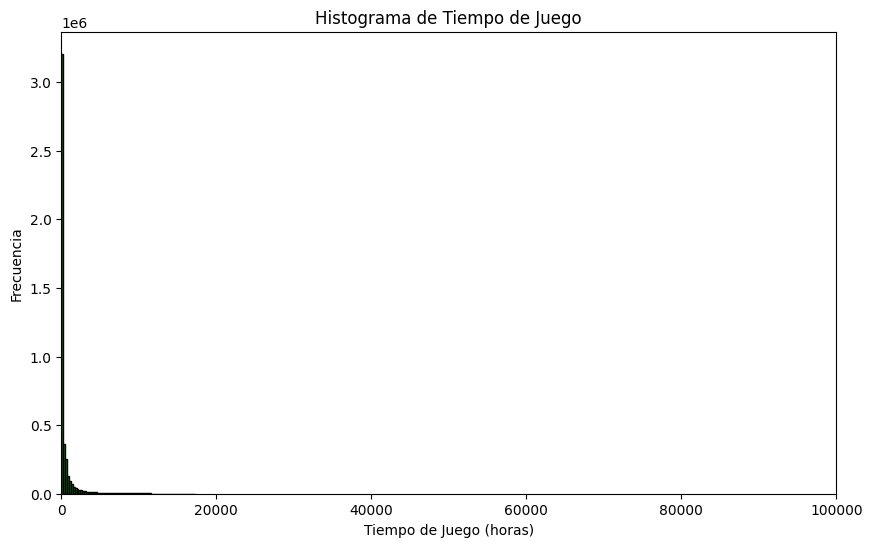

In [72]:
plt.figure(figsize=(10, 6))
plt.hist(df_items['playtime_forever'], bins=70, color='green', edgecolor='black')
plt.xlabel('Tiempo de Juego (horas)')
plt.ylabel('Frecuencia')
plt.title('Histograma de Tiempo de Juego')
plt.xlim(0, 100000)
plt.show()

DISTRIBUCION DE JUEGOS MAS JUGADOS

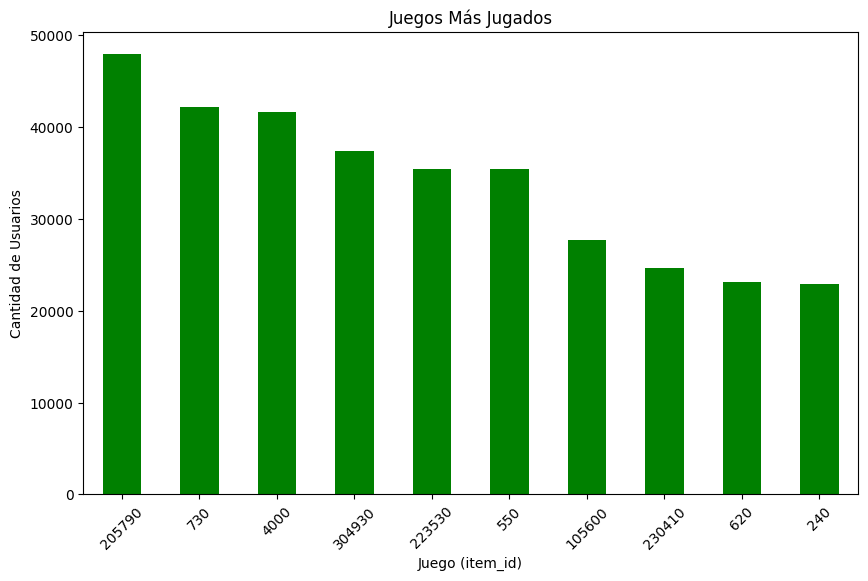

In [73]:
top_played_games = df_items['item_id'].value_counts().head(10)
plt.figure(figsize=(10, 6))
top_played_games.plot(kind='bar', color='green')
plt.xlabel('Juego (item_id)')
plt.ylabel('Cantidad de Usuarios')
plt.title('Juegos Más Jugados')
plt.xticks(rotation=45)
plt.show()

DIAGRAMA DE DISPERSION (TIEMPO DE JUEGO VS CANTIDAD DE JUEGOS POR USUARIO)

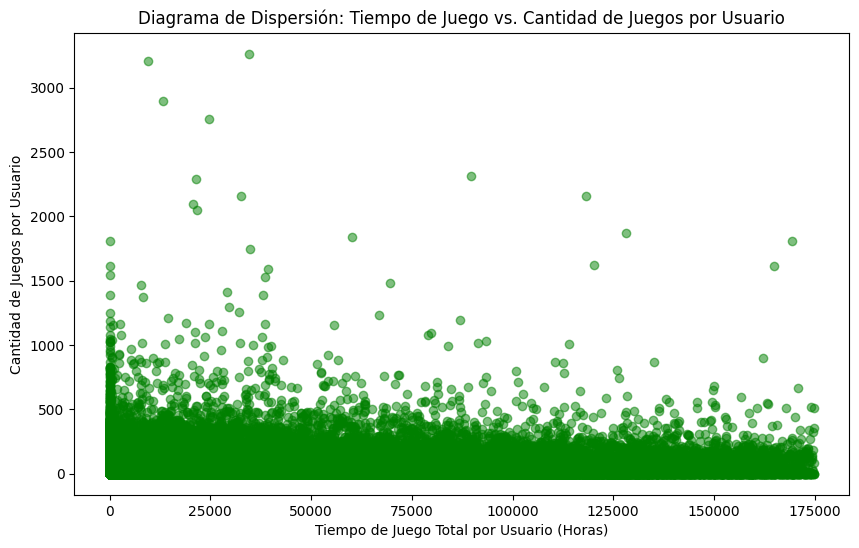

In [74]:
plt.figure(figsize=(10, 6))
plt.scatter(df_items.groupby('user_id')['playtime_forever'].sum(), df_items['user_id'].value_counts(), alpha=0.5, color='green')
plt.xlabel('Tiempo de Juego Total por Usuario (Horas)')
plt.ylabel('Cantidad de Juegos por Usuario')
plt.title('Diagrama de Dispersión: Tiempo de Juego vs. Cantidad de Juegos por Usuario')
plt.show()

## **ARCHIVOS REDUCIDOS - FUNCIONES - API**

**OPERACIONES REALIZADAS**

Se crearan archivos reducidos que contengan los datos necesarios para llevar a cabo las consultas solicitadas y sean consumidos por la API. Estos archivos serán independientes para cada función.

1. def developer(desarollador): Cantidad de items y porcentaje de contenido Free por año según empresa desarrolladora.

In [75]:
#Se duplica el df_games en df_year
df_year = df_games.copy()

#Se extrae el año de la columna 'release_date'
df_year['year'] = df_year['release_date'].str[:4]
df_year['year'] = pd.to_numeric(df_year['year'], errors='coerce')

#Se filtran los registros con año igual a 1970
df_year = df_year[df_year['year'] != 1970]

#Se calcula los 'items_count' por desarrollador y año
developer_items_count = df_year.groupby(['developer', 'year'])['item_id'].count().reset_index()
developer_items_count.rename(columns={'item_id': 'items_count'}, inplace=True)
#Se calcula los 'free_games' por desarrollador y año
developer_free_games = df_year[df_year['price'] == 0].groupby(['developer', 'year'])['item_id'].count().reset_index()
developer_free_games.rename(columns={'item_id': 'free_count'}, inplace=True)

#Se combina los df para calcular el porcentaje
df_content_developer = developer_items_count.merge(developer_free_games, on=['developer', 'year'], how='left')
df_content_developer['free_content'] = (df_content_developer['free_count'] / df_content_developer['items_count']) * 100
df_content_developer.drop(columns=['free_count'], inplace=True)
df_content_developer['free_content'].fillna(0, inplace=True)

#Se visualiza
df_content_developer.head()

,developer,year,items_count,free_content
0,+7 Software,2016,1,0.0
1,"+Mpact Games, LLC.",2017,1,0.0
2,.M.Y.W.,2016,1,0.0
3,.ez Games,2017,1,0.0
4,07th Expansion,2015,2,0.0


Se exporta el df_content_developer a parquet

In [76]:
tabla_parquet_fun1 = pa.Table.from_pandas(df_content_developer)
pq.write_table(tabla_parquet_fun1, 'developer')

2. def userdata(user_id): Cantidad de dinero gastado por el usuario, el porcentaje de recomendación en base a recomendaciones y cantidad de items

In [77]:
#Se crea un DF vacío
df_userdata = pd.DataFrame()
#Se le agrega la columna 'user_id'
df_userdata['user_id'] = df_items['user_id'].unique()
df_userdata.shape[0]

86206

Sumamos en un df todo el dinero gastado por el usuario

In [78]:
#Se crea un DataFrame entre steam y users para tener el precio en el item_id
df_merged_price = df_items.merge(df_games, on='item_id', how='left')
df_merged_price['price'] = df_merged_price['price'].astype(float)
#Total de Gastos/price (sum) por usuario
df_spent = pd.merge(df_userdata, df_merged_price.groupby('user_id')['price'].sum().reset_index(), on='user_id', how='left')
#Modificamos el nombre de la columna calculada
df_spent.rename(columns={"price": "spent"}, inplace=True)
df_spent.head()

,user_id,spent
0,js41637,8642.98
1,evcentric,1614.87
2,Riot-Punch,3477.12
3,maplemage,7462.88
4,Wackky,0.00


Agrupamos las recomendaciones y sacamos el porcentaje por usuario en un df

In [79]:
#Se agrupan por ususario recomendaciones negativas
df_recommend_negative = df_reviews[df_reviews['recommend'] == 0].groupby('user_id')['recommend'].count().reset_index()
df_recommend_negative.rename(columns={"recommend": "recommend_0"}, inplace=True)
#Se agrupan por usuario recomendaciones positivas
df_recommend_positive = df_reviews[df_reviews['recommend'] == 1].groupby('user_id')['recommend'].count().reset_index()
df_recommend_positive.rename(columns={"recommend": "recommend_1"}, inplace=True)
#Se realiza un merge de ambos df
df_recommend = pd.merge(df_recommend_negative,df_recommend_positive, on='user_id', how='inner')

#Se calcula en una nueva columna el total de recomendaciones por usuario
df_recommend['total_recommend'] = df_recommend['recommend_0'] + df_recommend['recommend_1']
df_recommend['total_recommend'] = df_recommend['total_recommend'].astype(int)
#Se crea una columna para hallar el porcentaje
df_recommend['percentage_recommend'] = 0
df_recommend['percentage_recommend'] = df_recommend['percentage_recommend'].astype(float)
#Se crea  una mascara para evitar la division por 0
nonzero_mask = df_recommend['total_recommend'] != 0 
df_recommend.loc[nonzero_mask, 'percentage_recommend'] = (df_recommend['recommend_1'] / df_recommend['total_recommend']) * 100

#Se junta en un df el usuario y las recomendaciones
df_percentage_recommend = pd.merge(df_userdata,df_recommend, on='user_id', how='left')

#Se reemplaza los valores nulos
df_percentage_recommend['recommend_0'].fillna(0, inplace=True)
df_percentage_recommend['recommend_1'].fillna(0, inplace=True)
df_percentage_recommend['total_recommend'].fillna(0, inplace=True)
df_percentage_recommend['percentage_recommend'].fillna(0, inplace=True)

#Se convierte el tipo de dato de la columna 'percentage_recommend' a float
df_percentage_recommend['recommend_0'] = df_percentage_recommend['recommend_0'].astype(float)
df_percentage_recommend['recommend_1'] = df_percentage_recommend['recommend_1'].astype(float)
df_percentage_recommend['total_recommend'] = df_percentage_recommend['total_recommend'].astype(float)
df_percentage_recommend['percentage_recommend'] = df_percentage_recommend['percentage_recommend'].astype(float)
df_percentage_recommend.head()

,user_id,recommend_0,recommend_1,total_recommend,percentage_recommend
0,js41637,0.0,0.0,0.0,0.0
1,evcentric,0.0,0.0,0.0,0.0
2,Riot-Punch,0.0,0.0,0.0,0.0
3,maplemage,0.0,0.0,0.0,0.0
4,Wackky,0.0,0.0,0.0,0.0


Se crea un df que contenga la cantidad de items por usuario

In [80]:
#Se crea un DF vacío
df_count_items = pd.DataFrame()
#Se le agrega la columna 'user_id'
df_count_items['user_id'] = df_items['user_id'].unique()
df_count_items.shape[0]

86206

In [81]:
#Se agrega la columna cantidad de items
df_count_items = pd.merge(df_count_items, df_items.groupby('user_id')['item_id'].count().reset_index(), on='user_id', how='left')
#Se modifica el nombre de la columna calculada
df_count_items.rename(columns={"item_id": "count_items"}, inplace=True)
#Se reemplaza los valores nulos por ceros 
df_count_items['count_items'].fillna(0, inplace=True)
#Se modifica el tipo de dato a entero (int)
df_count_items['count_items'] = df_count_items['count_items'].astype(int)

Se unen los df y se exportan a parquet

In [82]:
df_userdata = df_spent.merge(df_percentage_recommend, on='user_id', how='outer')
df_userdata = df_userdata.merge(df_count_items, on='user_id', how='outer')
#Se eliminan las columnas innecesarias
df_userdata = df_userdata.drop(["recommend_0", "recommend_1", "total_recommend"], axis=1)
#Se ajusta el formato a cada columna
df_userdata['spent'] = df_userdata['spent'].astype(float)
df_userdata['percentage_recommend'] = df_userdata['percentage_recommend'].astype(float)
df_userdata['count_items'] = df_userdata['count_items'].astype(int)
df_userdata.head()

,user_id,spent,percentage_recommend,count_items
0,js41637,8642.98,0.0,888
1,evcentric,1614.87,0.0,137
2,Riot-Punch,3477.12,0.0,328
3,maplemage,7462.88,0.0,629
4,Wackky,0.00,0.0,1


Se exporta el df_userdata a parquet

In [83]:
tabla_parquet_fun2 = pa.Table.from_pandas(df_userdata)
pq.write_table(tabla_parquet_fun2, 'user_data')

3. def UserForGenre(genre): Debe devolver el usuario que acumula más horas jugadas para el género dado y una lista de la acumulación de horas jugadas por año de lanzamiento.

In [84]:
#Se separa los géneros y se agregan como filas separadas en df_games_cp
df_games_cp = df_games.copy()
df_games_cp['genres'] = df_games_cp['genres'].str.split(', ')
df_games_expanded = df_games_cp.explode('genres')

#Se combinan df_games_expanded y df_item
df_combined = df_items.merge(df_games_expanded, on='item_id', how='inner')

#Se calcula las horas jugadas por usuario y género
user_genre_playtime = df_combined.groupby(['user_id', 'genres'])['playtime_forever'].sum().reset_index()

#Se encuentra al usuario con más horas jugadas para cada género
idx = user_genre_playtime.groupby('genres')['playtime_forever'].idxmax()
user_most_played_by_genre = user_genre_playtime.loc[idx]

#Se crea un df con los resultados
result_df = user_most_played_by_genre
result_df.reset_index(drop=True, inplace=True)
pd.options.display.float_format = '{:.2f}'.format
result_df

,user_id,genres,playtime_forever
0,Zombiepig950,Action,149769.11
1,76561198077273975,Adventure,96947.00
2,HappyRussian,Audio Production,16662.00
3,Arkvoir,Casual,54595.00
4,76561198138691719,Early Access,45284.00
5,Adrian_31,Education,8404.00
6,76561198087693951,Free to Play,95949.23
7,76561198063361762,Illustration,20004.00
8,76561198065109539,Indie,114319.11
9,76561198043463874,Massively Multiplayer,62146.00


Una vez se obtiene el user_id con mayor 'playtime_forever' según el género, se busca las horas jugadas por año de lanzamiento

In [85]:
combined_df = df_items.merge(df_games[['item_id', 'release_date', 'genres']], on='item_id', how='inner')

#Se convierte la columna 'release_date' a tipo datetime para extraer el año
combined_df['release_date'] = pd.to_datetime(combined_df['release_date'])
combined_df['release_year'] = combined_df['release_date'].dt.year

#Se separan los géneros y crear filas separadas para cada género
combined_df = combined_df.assign(genres=combined_df['genres'].str.split(', ')).explode('genres')

#Se calcula las sumas de 'playtime_forever' para juegos con el mismo año de lanzamiento, género y usuario
user_yearly_genre_playtime = combined_df.groupby(['user_id', 'release_year', 'genres'])['playtime_forever'].sum().reset_index()

#Se agrupan los datos en un formato de lista para cada usuario
user_yearly_genre_playtime_grouped = user_yearly_genre_playtime.groupby(['user_id', 'genres']).apply(lambda x: x[['release_year', 'playtime_forever']].to_dict(orient='records')).reset_index()
user_yearly_genre_playtime_grouped.columns = ['user_id', 'genres', 'Año y Horas']

#Se combinan con result_df para agregar la nueva columna
result_df = result_df.merge(user_yearly_genre_playtime_grouped, on=['user_id', 'genres'], how='left')

#Se visualiza el resultado
result_df

,user_id,genres,playtime_forever,Año y Horas
0,Zombiepig950,Action,149769.11,"[{'release_year': 1970, 'playtime_forever': 49..."
1,76561198077273975,Adventure,96947.00,"[{'release_year': 2007, 'playtime_forever': 0...."
2,HappyRussian,Audio Production,16662.00,"[{'release_year': 2013, 'playtime_forever': 16..."
3,Arkvoir,Casual,54595.00,"[{'release_year': 2010, 'playtime_forever': 0...."
4,76561198138691719,Early Access,45284.00,"[{'release_year': 2013, 'playtime_forever': 20..."
5,Adrian_31,Education,8404.00,"[{'release_year': 2013, 'playtime_forever': 84..."
6,76561198087693951,Free to Play,95949.23,"[{'release_year': 2010, 'playtime_forever': 84..."
7,76561198063361762,Illustration,20004.00,"[{'release_year': 2007, 'playtime_forever': 0...."
8,76561198065109539,Indie,114319.11,"[{'release_year': 2006, 'playtime_forever': 0...."
9,76561198043463874,Massively Multiplayer,62146.00,"[{'release_year': 2008, 'playtime_forever': 4...."


Se reemplaza de los diccionarios el 'release_year' y el 'playtime_forever'

In [88]:
df_userforgenre = result_df.copy()
df_userforgenre = df_userforgenre.drop(columns=['playtime_forever'])
df_userforgenre['Año y Horas'] = df_userforgenre['Año y Horas'].apply(lambda x: [{'Año': item['release_year'], 'Horas': item['playtime_forever']} for item in x])
df_userforgenre = df_userforgenre.rename(columns={'Año y Horas': 'Horas_Jugadas'})
df_userforgenre

,user_id,genres,Horas_Jugadas
0,Zombiepig950,Action,"[{'Año': 1970, 'Horas': 4966.0}, {'Año': 1997,..."
1,76561198077273975,Adventure,"[{'Año': 2007, 'Horas': 0.0}, {'Año': 2009, 'H..."
2,HappyRussian,Audio Production,"[{'Año': 2013, 'Horas': 16662.0}]"
3,Arkvoir,Casual,"[{'Año': 2010, 'Horas': 0.0}, {'Año': 2011, 'H..."
4,76561198138691719,Early Access,"[{'Año': 2013, 'Horas': 20376.0}, {'Año': 2014..."
5,Adrian_31,Education,"[{'Año': 2013, 'Horas': 8404.0}]"
6,76561198087693951,Free to Play,"[{'Año': 2010, 'Horas': 84.0}, {'Año': 2011, '..."
7,76561198063361762,Illustration,"[{'Año': 2007, 'Horas': 0.0}, {'Año': 2012, 'H..."
8,76561198065109539,Indie,"[{'Año': 2006, 'Horas': 0.0}, {'Año': 2011, 'H..."
9,76561198043463874,Massively Multiplayer,"[{'Año': 2008, 'Horas': 4.0}, {'Año': 2009, 'H..."


Se exporta el df_userforgenre a parquet

In [89]:
tabla_parquet_fun3 = pa.Table.from_pandas(df_userforgenre)
pq.write_table(tabla_parquet_fun3, 'user_for_genre')

4. def best_developer_year( año ): Devuelve el top 3 de desarrolladores con juegos MÁS recomendados por usuarios para el año dado. (reviews.recommend = True y comentarios positivos)

In [90]:
#Se filtran las reviews por recomendaciones y comentarios positivos
df_filtered_reviews = df_reviews[(df_reviews['recommend'] == 1) & (df_reviews['sentiment_analysis'] == 2)]

#Se combinan los DataFrames para obtener el año de lanzamiento
df_combined = df_filtered_reviews.merge(df_games[['item_id', 'developer', 'release_date']], on='item_id', how='left')
df_combined['release_year'] = pd.to_datetime(df_combined['release_date']).dt.year

#Se agrupan por año y desarrollador, y se realiza el conteo por número de juegos recomendados
developer_recommendations = df_combined.groupby(['release_year', 'developer'])['item_id'].count().reset_index()
developer_recommendations.rename(columns={'item_id': 'total_recommendations'}, inplace=True)

#Se busca el top 3 de desarrolladores para cada año
top_3_developers = developer_recommendations.groupby('release_year').apply(lambda x: x.nlargest(3, 'total_recommendations')['developer'].tolist()).reset_index(name='Top Developers')

#Se divide la lista de Top Developers en columnas separadas
top_developers_df = top_3_developers['Top Developers'].apply(pd.Series)
top_developers_df.columns = ['Top 1', 'Top 2', 'Top 3']

#Se concatena el df
df_best_developer_year = pd.concat([top_3_developers.drop('Top Developers', axis=1), top_developers_df], axis=1)
#Se renombra la columna de año
df_best_developer_year.rename(columns={'release_year': 'Año'}, inplace=True)

#Se visualiza el resultado
df_best_developer_year.head()

,Año,Top 1,Top 2,Top 3
0,1970.00,Unknown,United Front Games,Futuremark
1,1990.00,id Software,LucasArts,NaN
2,1991.00,3D Realms (Apogee Software),NaN,NaN
3,1992.00,Redwood Games,NaN,NaN
4,1993.00,"MicroProse Software, Inc",NaN,NaN


Se exporta el df_best_developer_year a parquet

In [91]:
tabla_parquet_fun4 = pa.Table.from_pandas(df_best_developer_year)
pq.write_table(tabla_parquet_fun4, 'best_developer_year')

5. def developer_reviews_analysis( desarrolladora ): Según el desarrollador, se devuelve un diccionario con el nombre del desarrollador como llave y una lista con la cantidad total de registros de reseñas de usuarios que se encuentren categorizados con un análisis de sentimiento como valor positivo o negativo.

In [92]:
#Se filtran las reviews por analisis de sentimiento
df_filtered_reviews = df_reviews[df_reviews['sentiment_analysis'].isin([0, 2])]

#Se combinan los df para obtener el desarrollador de cada juego
df_combined = df_filtered_reviews.merge(df_games[['item_id', 'developer']], on='item_id', how='left')

#Se agrupan por desarrollador y se cuenta los valores positivos y negativos
df_developer_reviews_analysis = df_combined.groupby('developer')['sentiment_analysis'].value_counts().unstack(fill_value=0)
df_developer_reviews_analysis.reset_index(inplace=True)

#Se crea un df con todas las desarrolladoras disponibles en df_games
all_developers = pd.DataFrame({'developer': df_games['developer'].unique()})

#Se combinan los df para completar los registros faltantes
df_developer_reviews_analysis = all_developers.merge(df_developer_reviews_analysis, on='developer', how='left')

#Se convierte los valores vacios a 0
df_developer_reviews_analysis[2].fillna(0, inplace=True)
df_developer_reviews_analysis[0].fillna(0, inplace=True)
df_developer_reviews_analysis.columns = ['developer', 'Negative', 'Positive']

#Se visualiza el df
df_developer_reviews_analysis

,developer,Negative,Positive
0,Kotoshiro,0.00,0.00
1,Secret Level SRL,0.00,0.00
2,Poolians.com,0.00,0.00
3,彼岸领域,0.00,0.00
4,Unknown,283.00,1063.00
...,...,...,...
10988,Fred Ells,0.00,0.00
10989,VersoVR,0.00,0.00
10990,"Oscar Ortigueira López,OrtiGames/OrtiSoft",0.00,0.00
10991,INGAME,0.00,0.00


Se exporta el df_developer_review_analysis a parquet

In [93]:
tabla_parquet_fun5 = pa.Table.from_pandas(df_developer_reviews_analysis)
pq.write_table(tabla_parquet_fun5, 'developer_reviews_analysis')